# Packages

In [1]:
!pip install pandas
!pip install numpy
!pip3 install mesa
!pip3 install mesa.time
!pip3 install random2

import pandas as pd
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
import random2
import random
import copy
from itertools import count

import matplotlib.pyplot as plt

from re import U

import numpy as np
from scipy.stats import entropy
import math
from scipy.stats import pearsonr



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement mesa.time (from versions: none)
ERROR: No matching distribution found for mesa.time
  Preparing metadata (setup.py) ... done
  Created wheel for random2: filename=random2-1.0.1-py3-none-any.whl size=12042 sha256=93020e8c474345b5e7932e741dbd276c274724d4bbc334f69af4183687353d08
  Stored in directory: /root/.cache/pip/wheels/61/1f/84/8713326a151c1638e7a00202e4074b46e839d22b7d22f8400f
Successfully built random2


# Model

In [2]:
class Language_Model:
    def __init__(self, number_of_agents, number_of_features, max_number_of_states,
                 grid_size,shortcut_pct, interaction_likelihood,inheritance_rate_lower,inheritance_rate_higher,
                 birth_likelihood,child_relocation_likelihood,birthing_stop):
        self.number_of_agents = number_of_agents
        self.number_of_features = number_of_features
        self.agents = []

        self.grid_size = grid_size  # https://stackoverflow.com/questions/2397141/how-to-initialize-a-two-dimensional-array-in-python
        self.grid = []
        self.cell_list = [] # To prevent multiple agents in single cell
        for height in range(self.grid_size):
          row = []
          for width in range(self.grid_size):
            row.append([])
          self.grid.append(row)
        self.state_values = {}
        # Interaction likelihood
        self.interaction_likelihood = interaction_likelihood
        self.birthing_stop = int(birthing_stop)
        self.inheritance_lower = inheritance_rate_lower
        self.inheritance_higher = inheritance_rate_higher
        self.birthrate = birth_likelihood
        self.birth_relocate = child_relocation_likelihood
        self.inheritance_list = {}
        self.inheritance_states = {}
        self.shortcut_pct = shortcut_pct
        self.shortcutted_cells = 2*(((self.grid_size)**2)*self.shortcut_pct)
        self.shortcut_list = []

        while len(self.shortcut_list) <= self.shortcutted_cells:
            short_cord = (random.randint(0, grid_size-1),random.randint(0, grid_size-1))
            if short_cord not in self.shortcut_list:
              self.shortcut_list.append(short_cord)
            else:
              pass

        self.shortcut_pairs = [self.shortcut_list[pos:pos+2] for pos in range(0, int(self.shortcutted_cells), 2)]

        for state_id in range(1,number_of_features+1):
          number_of_states = random.randint(2, max_number_of_states) # Min 2 states (binary), max 9
          self.state_values[f"Feature_{state_id}"] = random.sample(["A","B","C","D","E","F","G","H","I"], number_of_states)

        for agent_id in range(self.number_of_agents):
            agent_features = {}
            agent_features['agent_id'] = agent_id
            agent_features['family'] = f"family {agent_id}"
            #print(agent_features)
            for feature_id in range(1, self.number_of_features + 1):
                feature_name = "Feature_" + str(feature_id)
                feature_value = random.choice(self.state_values[feature_name])
                agent_features[feature_name] = feature_value

            while True:
                x = np.random.randint(0, self.grid_size-1)
                y = np.random.randint(0, self.grid_size-1)
                cell = (x, y)
                if cell not in self.cell_list:
                    self.cell_list.append(cell)
                    agent_features['cell_location'] = cell
                    break

            self.grid[x][y].append(agent_features)
            self.agents.append(agent_features)

    def neighbour_identification(self,cell):
        x, y = cell['cell_location']
        id = cell['agent_id']
        neighbours_list = []

        for horizontal in range(-1, 2):
            for vertical in range(-1, 2):
                #if (horizontal, vertical) != (0, 0):
                neighbour_x, neighbour_y = x + horizontal, y + vertical
                if 0 <= neighbour_x < self.grid_size and 0 <= neighbour_y < self.grid_size:
                    neighbour_cell = (neighbour_x, neighbour_y)
                    agents_in_neighbour = self.grid[neighbour_x][neighbour_y]
                    neighbours_list.extend(agents_in_neighbour)

        if cell in self.shortcut_list:
              for pair in self.shortcut_pairs:
                if cell in pair:
                  for first, second in pair:
                    if cell == first:
                        neighbours_list.extend(self.grid[second[0]][second[1]])
                    if cell == second:
                        neighbours_list.extend(self.grid[first[0]][first[1]])

        return neighbours_list

    def interaction(self,agent_features,neighbour_features):
      keys_to_remove = ['agent_id','cell_location','family']
      pure_features = agent_features.copy()
      for key in keys_to_remove:
        del pure_features[key]
      absorbed_feature = random.choice(list(pure_features.keys()))
      del agent_features[absorbed_feature]
      agent_features[absorbed_feature] = neighbour_features[absorbed_feature]
      return agent_features

    def child_creation(self, parent):
        pure_features = parent.copy()
        keys_to_remove = ['agent_id','cell_location','family']
        for key in keys_to_remove:
          del pure_features[key]
        child = pure_features.copy()

        inheritance_value = (random.uniform(self.inheritance_lower, self.inheritance_higher))

        count_to_inherit = round(inheritance_value*len(list(pure_features.keys())),0)
        shuffled_features = list(pure_features.keys())
        random.shuffle(shuffled_features)                       # https://stackoverflow.com/questions/41168267/is-it-possible-to-create-a-new-list-from-a-shuffled-list

        features_to_inherit = shuffled_features[:int(count_to_inherit)]

        child['agent_id'] = 'C'+str(len(self.agents)) # Child ID will be 1 more than last, and has C as identifier
        self.inheritance_states[child['agent_id']]= {}
        child['family']=parent['family']
        for feature_name in pure_features:
          if feature_name in features_to_inherit:
                child[feature_name] = parent[feature_name]
                self.inheritance_states[child['agent_id']][feature_name]={"value":child[feature_name],"cause":"inherited"}

          else:
                feature_n = int(feature_name.split('_')[1].replace('_',''))
                child[feature_name] = random.choice(self.state_values[feature_name])
                self.inheritance_states[child['agent_id']][feature_name]={"value":child[feature_name],"cause":"not inherited"}
        parent_x, parent_y = parent['cell_location']

        if random.random() < self.birth_relocate:
            random_x_change = random.choice([-1,0,1])
            random_y_change = random.choice([-1,0,1])

            while (random_x_change == 0 and random_y_change == 0) or ((parent_x-random_x_change < 0) or (parent_x-random_x_change >= self.grid_size) or (parent_y-random_y_change < 0) or (parent_y-random_y_change >= self.grid_size)): # Preventing 0,0 coord == no change
                random_x_change = random.choice([-1,0,1])
                random_y_change = random.choice([-1,0,1])
            child_x, child_y = parent_x-random_x_change, parent_y-random_y_change
        else:
            child_x, child_y = parent_x, parent_y  # Child starts in the same cell as the parent
        self.inheritance_list.update({child['agent_id']:{"birth_cell":(child_x, child_y),"inheritance value":inheritance_value}})
        self.grid[child_x][child_y].append(child)
        child['cell_location'] = child_x, child_y
        self.agents.append(child)

        return child

    def run_interaction_step(self,step):
        for agent_dict in self.agents:
            x, y = agent_dict['cell_location']
            agents_in_neighbour = self.neighbour_identification(agent_dict)



            #if sum(isinstance(agent_dict, dict) for agent_dict in agents_in_neighbour)>1:
            #if agents_in_neighbour:
            if (random.random() < self.interaction_likelihood) and len(agents_in_neighbour) >= 2:

                      interacting_neighbour = random.choice(agents_in_neighbour)
                      while interacting_neighbour['agent_id'] == agent_dict['agent_id']:
                          interacting_neighbour = random.choice(agents_in_neighbour)

                      agent_dict = self.interaction(agent_dict, interacting_neighbour)
            if self.step < self.birthing_stop:
                if random.random() < self.birthrate:
                    parent = agent_dict
                    child = self.child_creation(parent)

    def agent_details(self):
      print('self.agents')
      print(self.agents)
      print('-'*20)

      for agent in self.agents:
        print(agent['cell_location'])

      print('self.grid')
      print(self.grid)
      print('-'*20)

      print('self.shortcut_list')
      print(self.shortcut_list)
      print('-'*20)


    def what_is_my_state(self):
        agent_states = []
        for agent_cell in self.agents:
            x, y = agent_cell['cell_location']
            agents_in_cell = self.grid[x][y]

            for agent in agents_in_cell:
                agent_ind_feature = copy.deepcopy(agent)
                agent_states.append(agent_ind_feature)

        return agent_states


    def what_is_my_df(self, agent_states):
        agent_data = []
        for step, agent_state in enumerate(agent_states):
            for agent in agent_state:
                agent_id = agent['agent_id']
                agent_info = agent.copy()
                del agent_info['agent_id']
                agent_info['agent_id'] = agent_id
                agent_info['step'] = step+1  # Add the step information
                agent_data.append(agent_info)

        df = pd.DataFrame(agent_data).set_index('agent_id')
        return df


    def run_simulation(self, num_steps):
      feature_space = []
      for step in range(num_steps):
        self.step = step
        self.run_interaction_step(step)

        feature_space.append(self.what_is_my_state().copy())
      return self.what_is_my_df(feature_space), self.inheritance_list, self.inheritance_states, self.state_values

# Measures

In [3]:
def effect_measures(df,inheritance_dict, inheritance_states):
    reindexed_df = df.reset_index()
    df = reindexed_df.drop_duplicates(subset=['agent_id', 'step'], keep='first')
    df = df.set_index('agent_id')
                                                  #https://stackoverflow.com/questions/32093829/remove-duplicates-from-dataframe-based-on-two-columns-a-b-keeping-row-with-max
    step_one_df = df.loc[df['step']==1]
    step_one_df = step_one_df.drop(['cell_location','step','family'],axis=1)
    universal_running = 0
    feature_count = 0
    preferred_features = {}

    initial_states ={}

    #print(inheritance_states)
    #print(inheritance_dict)

    universal_initial = {}

    for x in step_one_df.columns:
      feature_count += 1
      universal_running += (step_one_df[x].value_counts()/len(step_one_df))[0]
      universal_initial[x] = (step_one_df[x].value_counts()/len(step_one_df))[0]
      preferred_features.update({x:step_one_df[x].value_counts().idxmax()})

    for x in step_one_df.index:
      initial_states[x] = step_one_df.loc[x, :].values.flatten().tolist()

    #print(initial_states)

    universal_preference = universal_running/feature_count

    inheritance_running = 0
    birth_count = len(inheritance_dict.keys())

    inherit_update_dict = {}

    for key in inheritance_dict:
      inheritance_running += inheritance_dict[key]['inheritance value']

    if birth_count == 0:
        pass
    else:
        inheritance = inheritance_running/birth_count

    birth_states = 0
    inherited_values = 0
    non_inherited = 0
    universal_pref_birth = 0
    child_dict = {}
    for key in inheritance_states:
        child_dict[key]={}
        for val in inheritance_states[key]:
            child_dict[key][val] =  inheritance_states[key][val]['cause']

            birth_states += 1
            if child_dict[key][val] == 'inherited':
              inherited_values += 1
            else:
              non_inherited += 1
              if preferred_features[val] == inheritance_states[key][val]['value']:
                universal_pref_birth += 1


    df.index = df.index.astype(str)
    for agent in df.index.unique():
      if 'C' in agent:
          agent_df = df.loc[df.index==agent]
          birth_step = agent_df['step'].min()
          birth_step_df = agent_df.loc[agent_df['step']==birth_step]
          birth_step_df = birth_step_df.drop(['cell_location','step','family'],axis=1)
          step_one_df = step_one_df.append(birth_step_df)

    child_free_df = df.loc[~df.index.str.contains('C',na=False)]

    change_dict = {}
    contact_change = 0
    for agent in df.index.unique():
        agent_df = df.loc[df.index==agent]
        agent_df = agent_df.drop(['cell_location','step','family'],axis=1)
        agent_total_changes = 0
        for feature in agent_df.columns:
            agent_df[f"{feature} change"] = agent_df[feature].shift(1, fill_value=agent_df[feature].head(1)) != agent_df[feature]
            if True in agent_df[f"{feature} change"].unique():
                contact_change += 1
                agent_total_changes += agent_df[f"{feature} change"].value_counts()[True]

        change_dict[agent] = agent_total_changes
    final_step_df = return_final_state(df)



    step_one_df.index = step_one_df.index.astype(str)
    final_step_df.index = final_step_df.index.astype(str)
    causes_dict = {}
    for agent in df.index.unique():
        causes_dict[agent] = {}
        agent_df = df.loc[df.index==agent]
        agent_df = agent_df.drop(['cell_location','step','family'],axis=1)
        if 'C' in agent:
            for x in agent_df.columns:
                init_val = step_one_df[x].loc[step_one_df.index==agent][0]
                final_val = final_step_df[x].loc[final_step_df.index==agent][0]
                whole_col = agent_df[x]
                if (init_val == final_val) and (len(whole_col.value_counts()) == 1):
                    if child_dict[agent][x] == 'inherited':
                        causes_dict[agent][x] = 'inheritance'
                    else:
                        causes_dict[agent][x] = 'universal preference'

                else:
                    causes_dict[agent][x] = 'contact'

        else:
            for x in agent_df.columns:
                init_val = step_one_df[x].loc[step_one_df.index==agent][0]
                final_val = final_step_df[x].loc[final_step_df.index==agent][0]
                whole_col = agent_df[x]

                if (init_val == final_val) and (len(whole_col.value_counts()) == 1):
                    causes_dict[agent][x] = 'universal preference'

                else:
                    causes_dict[agent][x] = 'contact'

    #print(initial_states)
    return pd.DataFrame.from_dict(causes_dict).T, final_step_df, universal_initial
#effect_measures(df1, inheritance_dict1, inherit_states1)

In [4]:
def return_final_state(df):
    reindexed_df = df.reset_index()
    df = reindexed_df.drop_duplicates(subset=['agent_id', 'step'], keep='first')
    df = df.set_index('agent_id')

    final_step = df['step'].max()
    final_step_df = df.loc[df['step']==final_step]
    final_step_df['cell_location'] = final_step_df['cell_location'].astype(str)

    final_step_df = final_step_df.drop(['step'], axis=1)

    return final_step_df

# return_final_state(df1)


In [5]:
def change_coord(df):
    df['x'] = df['cell_location'].str.split(',',expand=True)[0].str.replace('(',"")
    df['y'] = df['cell_location'].str.split(',',expand=True)[1].str.replace(' ',"").str.replace(')',"")

    return df.drop(columns=['cell_location'])


In [6]:
def final_counts(cause_df):

  return cause_df.apply(pd.Series.value_counts).head()

In [7]:
def cleaner(df):
  return df.drop(columns=['family','cell_location'])

# Experiments

## Statistical Functions

In [8]:
def entropy1(labels, base=None): # https://gist.github.com/virtadpt/a129f94e47c113f983a1ee361f837eb8
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

def pearson(normalized_entropy):
    contact_levels  = list(normalized_entropy.keys())
    entropy_values = list(normalized_entropy.values())
    corr_coeff, p_val = pearsonr(contact_levels, entropy_values)
    return corr_coeff, p_val


## Experiment Function

In [31]:
def experiment(number_of_agents,
               max_number_of_states,
               number_of_features,
               grid_size,
               shortcut_pct,
               inheritance_rate_lower,
               inheritance_rate_higher,
               birth_likelihood,
               child_relocation_likelihood,
               birthing_stop,
               number_of_iterations):

    state_dict = {}
    entro_dict = {}
    cause_dict = {}
    final_dict = {}
    uni_dict = {}
    perfect_dict = {}
    running_effect = {}

    whole_dict = {}

    contact = 0
    while contact <1.01:
        total_entropy = 0
        perfect_match = 0
        feature_n = 0
        cause_dict[contact] = {}
        final_dict[contact] = {}
        uni_dict[contact] = {}
        running_effect[contact] = {}

        u_p = 0
        inh = 0
        con = 0
        for z in range(0,10):
            model = Language_Model(number_of_agents=number_of_agents,                      # Initial number of languages
                              max_number_of_states=max_number_of_states,                   # Max number of states (Min is always 2, whatever you put is upper range)
                              number_of_features=number_of_features,                    # Number of features per language
                              grid_size=grid_size,                             # Size of grid world. If == 20: Grid == 20x20
                              shortcut_pct=shortcut_pct,                         # Percentage of cells that will be a shortcut
                              interaction_likelihood=contact,               # Chance to have contact with neighbour
                              inheritance_rate_lower=inheritance_rate_lower,              # Lower range of inheritance features (I suggest min 51%)
                              inheritance_rate_higher=inheritance_rate_higher,             # Max percentage of inheritance (Atleast 1 less than total feature count)
                              birth_likelihood=birth_likelihood,                     # Chance to have a child (if they do not interact)
                              child_relocation_likelihood=child_relocation_likelihood, # Chance child is born in a neighbouring cell
                              birthing_stop=birthing_stop)

            df, inheritance_dict, inherit_states, s_v = model.run_simulation(number_of_iterations)

            cause, final, universal_scores = effect_measures(df, inheritance_dict, inherit_states)
            try:
              u_p +=final_counts(cause).loc['universal preference'].sum()
            except:
              pass
            try:
              inh +=final_counts(cause).loc['inheritance'].sum()
            except:
              pass
            try:
              con +=final_counts(cause).loc['contact'].sum()
            except:
              pass

            for key in s_v:
              feature_n+=len(s_v[key])

            iter_entropy = 0
            for col in cleaner(final).columns:
                ent = entropy1(final[col].to_list())
                iter_entropy += ent
                if (ent == 0) or (ent == 0.0):
                  perfect_match += 1
            avg_entropy = iter_entropy/len(cleaner(final).columns)
            total_entropy += avg_entropy

            cause_dict[contact][z] = cause
            final_dict[contact][z] = final
            uni_dict[contact][z] = universal_scores


        perfect_dict[contact] = perfect_match
        running_effect[contact]['u_p'] = u_p
        running_effect[contact]['inh'] = inh
        running_effect[contact]['con'] = con
        entro_dict[contact] = total_entropy/10
        state_dict[contact] = feature_n/10

        whole_dict['perfect_dict'] = perfect_dict
        whole_dict['running_dict'] = running_effect
        whole_dict['entro_dict'] = entro_dict
        whole_dict['state_dict'] = state_dict
        whole_dict['cause_dict'] = cause_dict
        whole_dict['final_dict'] = final_dict
        whole_dict['uni_dict'] = uni_dict

        contact+=0.05

    normalized_entropy = {}
    for x in state_dict.keys():
        normalized_entropy[x] = entro_dict[x]/math.log2(state_dict[x])

    whole_dict['normalized_entropy'] = normalized_entropy

    return whole_dict

## Running Experiments

### Experiment 1

In [32]:
experiment_1 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

Streaming output truncated to the last 5000 lines.
<ipython-input-23-abe403d3e7fe>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  step_one_df = step_one_df.append(birth_step_df)
<ipython-input-23-abe403d3e7fe>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  step_one_df = step_one_df.append(birth_step_df)
<ipython-input-23-abe403d3e7fe>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  step_one_df = step_one_df.append(birth_step_df)
<ipython-input-23-abe403d3e7fe>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  step_one_df = step_one_df.append(birth_step_df)
<ipython-input-23-abe403d3e7fe>:71: FutureWarning: The frame.append metho

### Experiment 2

In [ ]:
experiment_2 = experiment(number_of_agents=20,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 3

In [ ]:
experiment_3 = experiment(number_of_agents=10,
                max_number_of_states=8,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 4

In [ ]:
experiment_4 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=20,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 5

In [ ]:
experiment_5 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=16,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 6

In [ ]:
experiment_6 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.4,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 7

In [ ]:
experiment_7 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.1,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 8

In [ ]:
experiment_8 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.5,
                birthing_stop = 21,
                number_of_iterations = 100)

### Experiment 9

In [ ]:
experiment_9 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 41,
                number_of_iterations = 100)

### Experiment 10

In [ ]:
experiment_10 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=8,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.25,
                birthing_stop = 21,
                number_of_iterations = 200)

### Experiment 11

In [ ]:
experiment_11 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=5,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.75,
                birthing_stop = 41,
                number_of_iterations = 100)

### Experiment 12

In [ ]:
experiment_12 = experiment(number_of_agents=10,
                max_number_of_states=4,
                number_of_features=10,
                grid_size=5,
                shortcut_pct=0.2,
                inheritance_rate_lower=0.50,
                inheritance_rate_higher=0.90,
                birth_likelihood=0.05,
                child_relocation_likelihood=0.75,
                birthing_stop = 21,
                number_of_iterations = 200)

## Visualisations

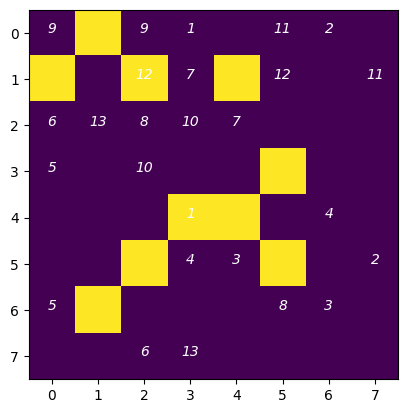

<ipython-input-4-1c0711b555e6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_step_df['cell_location'] = final_step_df['cell_location'].astype(str)
<ipython-input-5-9750c5911490>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['x'] = df['cell_location'].str.split(',',expand=True)[0].str.replace('(',"")
<ipython-input-5-9750c5911490>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['y'] = df['cell_location'].str.split(',',

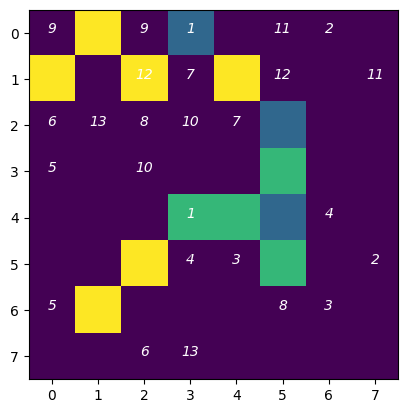

In [9]:
def visualize_grid(grid_size, agents,shortcut_pairs):
    # Create a grid of zeros
    grid = [[0] * grid_size for _ in range(grid_size)]
    # Mark the positions of the agents on the grid

    if isinstance(agents,pd.DataFrame):
      agents = change_coord(agents)

      for row in list(agents.index):
          x = agents.loc[row,'x']
          y = agents.loc[row,'y']
          row = str(row)
          if row.startswith('C'):
              if grid[int(x)][int(y)] != 0:
                  grid[int(x)][int(y)] = 3
              else:
                  grid[int(x)][int(y)] = 1
          else:
              if grid[int(x)][int(y)] != 0:
                  grid[int(x)][int(y)] = 3
              else:
                  grid[int(x)][int(y)] = 2
    else:
      for agent in agents:
        x, y = agent['cell_location']
        grid[x][y] = 1

    # Create a matplotlib figure and axis
    fig, ax = plt.subplots()

    pairing = 1
    for pair in shortcut_pairs:
      x1,y1 = pair[0]
      x2,y2=pair[1]
      ax.text(y1,x1,str(pairing),ha='center',color='white',fontstyle='oblique')
      ax.text(y2,x2,str(pairing),ha='center',color='white',fontstyle='oblique')
      pairing+=1

    #var_colours = {0:'blue',1:'red',2:'green',3:'purple'}

    ax.imshow(grid)


    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))

    plt.show()


model = Language_Model(number_of_agents=10, max_number_of_states=4, number_of_features=10,grid_size=8, shortcut_pct=0.2,interaction_likelihood=0.5,
                       inheritance_rate_lower=0.50,inheritance_rate_higher=0.75,birth_likelihood=0.05,child_relocation_likelihood=0.25,birthing_stop=21)

visualize_grid(model.grid_size,model.agents,model.shortcut_pairs)

df1, inheritance_dict1, inherit_states1,s_v = model.run_simulation(100)

visualize_grid(model.grid_size,return_final_state(df1),model.shortcut_pairs)

In [ ]:
all_entropy = {"Ex. 1": experiment_1['normalized_entropy'],
                   "Ex. 2": experiment_2['normalized_entropy'],
                   "Ex. 3": experiment_3['normalized_entropy'],
                   "Ex. 4": experiment_4['normalized_entropy'],
                   "Ex. 5": experiment_5['normalized_entropy'],
                   "Ex. 6": experiment_6['normalized_entropy'],
                   "Ex. 7": experiment_7['normalized_entropy'],
                   "Ex. 8": experiment_8['normalized_entropy'],
                   "Ex. 9": experiment_9['normalized_entropy'],
                   "Ex. 10": experiment_10['normalized_entropy']}

all_df = pd.DataFrame.from_dict(all_entropy).transpose()

all_df
plt.figure(figsize=(20, 600))


ax = all_df.transpose().plot.line(rot=0,subplots=True)
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Interactional Likelihood')
plt.ylabel('Normalized Entropy')

plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax = all_df.loc[['Ex. 1']].transpose().plot.line(rot=0,grid=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('Interactional Likelihood')
plt.ylabel('Normalized Entropy')

plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax = all_df.loc[['Ex. 2', 'Ex. 3','Ex. 4']].transpose().plot.line(rot=0,grid=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('Interactional Likelihood')
plt.ylabel('Normalized Entropy')

plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax = all_df.loc[['Ex. 5', 'Ex. 6','Ex. 7']].transpose().plot.line(rot=0,grid=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('Interactional Likelihood')
plt.ylabel('Normalized Entropy')

plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax = all_df.loc[['Ex. 8', 'Ex. 9','Ex. 10']].transpose().plot.line(rot=0,grid=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('Interactional Likelihood')
plt.ylabel('Normalized Entropy')

plt.show()

In [ ]:
print(pearson(experiment_1['normalized_entropy']))
print(pearson(experiment_2['normalized_entropy']))
print(pearson(experiment_3['normalized_entropy']))
print(pearson(experiment_4['normalized_entropy']))
print(pearson(experiment_5['normalized_entropy']))
print(pearson(experiment_6['normalized_entropy']))
print(pearson(experiment_7['normalized_entropy']))
print(pearson(experiment_8['normalized_entropy']))
print(pearson(experiment_9['normalized_entropy']))
print(pearson(experiment_10['normalized_entropy']))